# Libraries

In [1]:
import gc
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.offline

from colorama import Fore, Style, init
from pprint import pprint

# 🚫 Suppressing warnings 🚫
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
import seaborn as sns

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.offline

In [3]:
from scipy.stats import entropy
from collections import Counter
import polars as pl

In [4]:
from joblib import Parallel, delayed
from time import sleep, time
from multiprocessing import cpu_count

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
from imblearn.under_sampling import RandomUnderSampler
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
import xgboost as xgb

In [6]:
import numpy as np
import pandas as pd
import pandas.api.types
from typing import Dict, List, Tuple

tolerances = {
    'onset': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360], 
    'wakeup': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]
}

column_names = {
    'series_id_column_name': 'series_id',
    'time_column_name': 'step',
    'event_column_name': 'event',
    'score_column_name': 'score',
}

In [7]:
def score(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        tolerances: Dict[str, List[float]],
        series_id_column_name: str,
        time_column_name: str,
        event_column_name: str,
        score_column_name: str,
        use_scoring_intervals: bool = False,
) -> float:
    """Event Detection Average Precision, an AUCPR metric for event detection in
    time series and video.

    This metric is similar to IOU-threshold average precision metrics commonly
    used in object detection. For events occuring in time series, we replace the
    IOU threshold with a time tolerance.

    Submissions are evaluated on the average precision of detected events,
    averaged over timestamp error tolerance thresholds, averaged over event
    classes.

    Detections are matched to ground-truth events within error tolerances, with
    ambiguities resolved in order of decreasing confidence.

    Detailed Description
    --------------------
    Evaluation proceeds in four steps:

    1. Selection - (optional) Predictions not within a series' scoring
    intervals are dropped.
    2. Assignment - Predicted events are matched with ground-truth events.
    3. Scoring - Each group of predictions is scored against its corresponding
    group of ground-truth events via Average Precision.
    4. Reduction - The multiple AP scores are averaged to produce a single
    overall score.

    Selection

    With each series there may be a defined set of scoring intervals giving the
    intervals of time over which zero or more ground-truth events might be
    annotated in that series. A prediction will be evaluated only if it falls
    within a scoring interval. These scoring intervals can be chosen to improve
    the fairness of evaluation by, for instance, ignoring edge-cases or
    ambiguous events.

    It is recommended that, if used, scoring intervals be provided for training
    data but not test data.

    Assignment

    For each set of predictions and ground-truths within the same `event x
    tolerance x series_id` group, we match each ground-truth to the
    highest-confidence unmatched prediction occurring within the allowed
    tolerance.

    Some ground-truths may not be matched to a prediction and some predictions
    may not be matched to a ground-truth. They will still be accounted for in
    the scoring, however.

    Scoring

    Collecting the events within each `series_id`, we compute an Average
    Precision score for each `event x tolerance` group. The average precision
    score is the area under the (step-wise) precision-recall curve generated by
    decreasing confidence score thresholds over the predictions. In this
    calculation, matched predictions over the threshold are scored as TP and
    unmatched predictions as FP. Unmatched ground-truths are scored as FN.

    Reduction

    The final score is the average of the above AP scores, first averaged over
    tolerance, then over event.

    Parameters
    ----------
    solution : pd.DataFrame, with columns:

        `series_id_column_name` identifier for each time series

        `time_column_name` the time of occurence for each event as a numeric type

        `event_column_name` class label for each event

        The solution contains the time of occurence of one or more types of
        event within one or more time series. The metric expects the solution to
        contain the same event types as those given in `tolerances`.

        When `use_scoring_intervals == True`, you may include `start` and `end`
        events to delimit intervals within which detections will be scored.
        Detected events (from the user submission) outside of these events will
        be ignored.

    submission : pd.DataFrame, with columns as above and in addition:

        `score_column_name` the predicted confidence score for the detected event

    tolerances : Dict[str, List[float]]

        Maps each event class to a list of timestamp tolerances used
        for matching detections to ground-truth events.

    use_scoring_intervals: bool, default False

        Whether to ignore predicted events outside intervals delimited
        by `'start'` and `'end'` events in the solution. When `False`,
        the solution should not include `'start'` and `'end'` events.
        See the examples for illustration.

    Returns
    -------
    event_detection_ap : float
        The mean average precision of the detected events.

    Examples
    --------
    Detecting `'pass'` events in football:
    >>> column_names = {
    ...     'series_id_column_name': 'video_id',
    ...     'time_column_name': 'time',
    ...     'event_column_name': 'event',
    ...     'score_column_name': 'score',
    ... }
    >>> tolerances = {'pass': [1.0]}
    >>> solution = pd.DataFrame({
    ...     'video_id': ['a', 'a'],
    ...     'event': ['pass', 'pass'],
    ...     'time': [0, 15],
    ... })
    >>> submission = pd.DataFrame({
    ...     'video_id': ['a', 'a', 'a'],
    ...     'event': ['pass', 'pass', 'pass'],
    ...     'score': [1.0, 0.5, 1.0],
    ...     'time': [0, 10, 14.5],
    ... })
    >>> score(solution, submission, tolerances, **column_names)
    1.0

    Increasing the confidence score of the false detection above the true
    detections decreases the AP.
    >>> submission.loc[1, 'score'] = 1.5
    >>> score(solution, submission, tolerances, **column_names)
    0.6666666666666666...

    Likewise, decreasing the confidence score of a true detection below the
    false detection also decreases the AP.
    >>> submission.loc[1, 'score'] = 0.5  # reset
    >>> submission.loc[0, 'score'] = 0.0
    >>> score(solution, submission, tolerances, **column_names)
    0.8333333333333333...

    We average AP scores over tolerances. Previously, the detection at 14.5
    would match, but adding smaller tolerances gives AP scores where it does
    not match. This results in both a FN, since the ground-truth wasn't
    detected, and a FP, since the detected event matches no ground-truth.
    >>> tolerances = {'pass': [0.1, 0.2, 1.0]}
    >>> score(solution, submission, tolerances, **column_names)
    0.3888888888888888...

    We also average over time series and over event classes.
    >>> tolerances = {'pass': [0.5, 1.0], 'challenge': [0.25, 0.50]}
    >>> solution = pd.DataFrame({
    ...     'video_id': ['a', 'a', 'b'],
    ...     'event': ['pass', 'challenge', 'pass'],
    ...     'time': [0, 15, 0],  # restart time for new time series b
    ... })
    >>> submission = pd.DataFrame({
    ...     'video_id': ['a', 'a', 'b'],
    ...     'event': ['pass', 'challenge', 'pass'],
    ...     'score': [1.0, 0.5, 1.0],
    ...     'time': [0, 15, 0],
    ... })
    >>> score(solution, submission, tolerances, **column_names)
    1.0

    By adding scoring intervals to the solution, we may choose to ignore
    detections outside of those intervals.
    >>> tolerances = {'pass': [1.0]}
    >>> solution = pd.DataFrame({
    ...     'video_id': ['a', 'a', 'a', 'a'],
    ...     'event': ['start', 'pass', 'pass', 'end'],
    ...     'time': [0, 10, 20, 30],
    ... })
    >>> submission = pd.DataFrame({
    ...     'video_id': ['a', 'a', 'a'],
    ...     'event': ['pass', 'pass', 'pass'],
    ...     'score': [1.0, 1.0, 1.0],
    ...     'time': [10, 20, 40],
    ... })
    >>> score(solution, submission, tolerances, **column_names, use_scoring_intervals=True)
    1.0

    """
    # Validate metric parameters
    assert len(tolerances) > 0, "Events must have defined tolerances."
    assert set(tolerances.keys()) == set(solution[event_column_name]).difference({'start', 'end'}),        (f"Solution column {event_column_name} must contain the same events "
         "as defined in tolerances.")
    assert pd.api.types.is_numeric_dtype(solution[time_column_name]),        f"Solution column {time_column_name} must be of numeric type."

    # Validate submission format
    for column_name in [
        series_id_column_name,
        time_column_name,
        event_column_name,
        score_column_name,
    ]:
        if column_name not in submission.columns:
            raise ParticipantVisibleError(f"Submission must have column '{target_name}'.")

    if not pd.api.types.is_numeric_dtype(submission[time_column_name]):
        raise ParticipantVisibleError(
            f"Submission column '{time_column_name}' must be of numeric type."
        )
    if not pd.api.types.is_numeric_dtype(submission[score_column_name]):
        raise ParticipantVisibleError(
            f"Submission column '{score_column_name}' must be of numeric type."
        )

    # Set these globally to avoid passing around a bunch of arguments
    globals()['series_id_column_name'] = series_id_column_name
    globals()['time_column_name'] = time_column_name
    globals()['event_column_name'] = event_column_name
    globals()['score_column_name'] = score_column_name
    globals()['use_scoring_intervals'] = use_scoring_intervals

    return event_detection_ap(solution, submission, tolerances)


def filter_detections(
        detections: pd.DataFrame, intervals: pd.DataFrame
) -> pd.DataFrame:
    """Drop detections not inside a scoring interval."""
    detection_time = detections.loc[:, time_column_name].sort_values().to_numpy()
    intervals = intervals.to_numpy()
    is_scored = np.full_like(detection_time, False, dtype=bool)

    i, j = 0, 0
    while i < len(detection_time) and j < len(intervals):
        time = detection_time[i]
        int_ = intervals[j]

        # If the detection is prior in time to the interval, go to the next detection.
        if time < int_.left:
            i += 1
        # If the detection is inside the interval, keep it and go to the next detection.
        elif time in int_:
            is_scored[i] = True
            i += 1
        # If the detection is later in time, go to the next interval.
        else:
            j += 1

    return detections.loc[is_scored].reset_index(drop=True)


def match_detections(
        tolerance: float, ground_truths: pd.DataFrame, detections: pd.DataFrame
) -> pd.DataFrame:
    """Match detections to ground truth events. Arguments are taken from a common event x tolerance x series_id evaluation group."""
    detections_sorted = detections.sort_values(score_column_name, ascending=False).dropna()
    is_matched = np.full_like(detections_sorted[event_column_name], False, dtype=bool)
    gts_matched = set()
    for i, det in enumerate(detections_sorted.itertuples(index=False)):
        best_error = tolerance
        best_gt = None

        for gt in ground_truths.itertuples(index=False):
            error = abs(getattr(det, time_column_name) - getattr(gt, time_column_name))
            if error < best_error and gt not in gts_matched:
                best_gt = gt
                best_error = error

        if best_gt is not None:
            is_matched[i] = True
            gts_matched.add(best_gt)

    detections_sorted['matched'] = is_matched

    return detections_sorted


def precision_recall_curve(
        matches: np.ndarray, scores: np.ndarray, p: int
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    if len(matches) == 0:
        return [1], [0], []

    # Sort matches by decreasing confidence
    idxs = np.argsort(scores, kind='stable')[::-1]
    scores = scores[idxs]
    matches = matches[idxs]

    distinct_value_indices = np.where(np.diff(scores))[0]
    threshold_idxs = np.r_[distinct_value_indices, matches.size - 1]
    thresholds = scores[threshold_idxs]

    # Matches become TPs and non-matches FPs as confidence threshold decreases
    tps = np.cumsum(matches)[threshold_idxs]
    fps = np.cumsum(~matches)[threshold_idxs]

    precision = tps / (tps + fps)
    precision[np.isnan(precision)] = 0
    recall = tps / p  # total number of ground truths might be different than total number of matches

    # Stop when full recall attained and reverse the outputs so recall is non-increasing.
    last_ind = tps.searchsorted(tps[-1])
    sl = slice(last_ind, None, -1)

    # Final precision is 1 and final recall is 0
    return np.r_[precision[sl], 1], np.r_[recall[sl], 0], thresholds[sl]


def average_precision_score(matches: np.ndarray, scores: np.ndarray, p: int) -> float:
    precision, recall, _ = precision_recall_curve(matches, scores, p)
    # Compute step integral
    return -np.sum(np.diff(recall) * np.array(precision)[:-1])


def event_detection_ap(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        tolerances: Dict[str, List[float]],
) -> float:

    # Ensure solution and submission are sorted properly
    solution = solution.sort_values([series_id_column_name, time_column_name])
    submission = submission.sort_values([series_id_column_name, time_column_name])

    # Extract scoring intervals.
    if use_scoring_intervals:
        intervals = (
            solution
            .query("event in ['start', 'end']")
            .assign(interval=lambda x: x.groupby([series_id_column_name, event_column_name]).cumcount())
            .pivot(
                index='interval',
                columns=[series_id_column_name, event_column_name],
                values=time_column_name,
            )
            .stack(series_id_column_name)
            .swaplevel()
            .sort_index()
            .loc[:, ['start', 'end']]
            .apply(lambda x: pd.Interval(*x, closed='both'), axis=1)
        )

    # Extract ground-truth events.
    ground_truths = (
        solution
        .query("event not in ['start', 'end']")
        .reset_index(drop=True)
    )

    # Map each event class to its prevalence (needed for recall calculation)
    class_counts = ground_truths.value_counts(event_column_name).to_dict()

    # Create table for detections with a column indicating a match to a ground-truth event
    detections = submission.assign(matched = False)

    # Remove detections outside of scoring intervals
    if use_scoring_intervals:
        detections_filtered = []
        for (det_group, dets), (int_group, ints) in zip(
            detections.groupby(series_id_column_name), intervals.groupby(series_id_column_name)
        ):
            assert det_group == int_group
            detections_filtered.append(filter_detections(dets, ints))
        detections_filtered = pd.concat(detections_filtered, ignore_index=True)
    else:
        detections_filtered = detections

    # Create table of event-class x tolerance x series_id values
    aggregation_keys = pd.DataFrame(
        [(ev, tol, vid)
         for ev in tolerances.keys()
         for tol in tolerances[ev]
         for vid in ground_truths[series_id_column_name].unique()],
        columns=[event_column_name, 'tolerance', series_id_column_name],
    )

    # Create match evaluation groups: event-class x tolerance x series_id
    detections_grouped = (
        aggregation_keys
        .merge(detections_filtered, on=[event_column_name, series_id_column_name], how='left')
        .groupby([event_column_name, 'tolerance', series_id_column_name])
    )
    ground_truths_grouped = (
        aggregation_keys
        .merge(ground_truths, on=[event_column_name, series_id_column_name], how='left')
        .groupby([event_column_name, 'tolerance', series_id_column_name])
    )
    # Match detections to ground truth events by evaluation group
    detections_matched = []
    for key in aggregation_keys.itertuples(index=False):
        dets = detections_grouped.get_group(key)
        gts = ground_truths_grouped.get_group(key)
        detections_matched.append(
            match_detections(dets['tolerance'].iloc[0], gts, dets)
        )
    detections_matched = pd.concat(detections_matched)

    # Compute AP per event x tolerance group
    event_classes = ground_truths[event_column_name].unique()
    ap_table = (
        detections_matched
        .query("event in @event_classes")
        .groupby([event_column_name, 'tolerance']).apply(
            lambda group: average_precision_score(
                group['matched'].to_numpy(),
                group[score_column_name].to_numpy(),
                class_counts[group[event_column_name].iat[0]],
            )
        )
    )
    # Average over tolerances, then over event classes
    mean_ap = ap_table.groupby(event_column_name).mean().sum() / len(event_classes)

    return mean_ap

# Load models

In [8]:
import pickle

#with open('/kaggle/input/xgboost-scaled/xgboost_scaled_features.pkl', 'rb') as f:
with open('/kaggle/input/seb-training-classic-ml-model-v4-output/ensembler_model_xgb_SCM_V4.pkl', 'rb') as f:
    model_xgb = pickle.load(f)
model_xgb

with open('/kaggle/input/seb-training-classic-ml-model-v4-output/ensembler_lgb_SCM_V4.pkl', 'rb') as f:
    model_lgb = pickle.load(f)
model_lgb

with open('/kaggle/input/seb-training-classic-ml-model-v4-output/ensembler_boosting_SCM_V4.pkl', 'rb') as f:
    model_gradboostclass = pickle.load(f)
model_gradboostclass

with open('/kaggle/input/seb-training-classic-ml-model-v4-output/ensembler_randomforest_SCM_V4.pkl', 'rb') as f:
    model_randomforest = pickle.load(f)
model_randomforest

with open('/kaggle/input/seb-training-classic-ml-model-v4-output/ensembler_model_catboost_SCM_V4.pkl', 'rb') as f:
    model_catboost = pickle.load(f)
model_catboost

with open('/kaggle/input/seb-training-classic-ml-model-v4-output/ensembler_model_extratrees_SCM_V4.pkl', 'rb') as f:
    model_extratrees = pickle.load(f)
model_extratrees

ExtraTreesClassifier(min_samples_leaf=300, n_estimators=500, n_jobs=-1,
                     random_state=42)

# Useful functions

In [9]:
class EnsembleAvgProba():
    
    def __init__(self, classifiers):
        
        self.classifiers = classifiers
    
    def fit(self,X,y):
        
        for classifier in self.classifiers:                
            classifier.fit(X, y)
            gc.collect()
     
    def predict_proba(self, X):
        
        probs = []
        
        for m in self.classifiers:
            probs.append(m.predict_proba(X))
        
        probabilities = np.stack(probs)
        p = np.mean(probabilities, axis=0)
        
        return p 
    
    def predict(self, X):
        
        probs = []
        
        for m in self.classifiers:
            probs.append(m.predict(X))
        
        probabilities = np.stack(probs)
        p = np.mean(probabilities, axis=0)
        
        return p.round()

In [10]:
def reduce_mem_usage(df):
    
    """ 
    Iterate through all numeric columns of a dataframe and modify the data type
    to reduce memory usage.        
    """
    
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object and not is_datetime64_ns_dtype(df[col]) and not 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int32)  
            else:
                df[col] = df[col].astype(np.float16)
        
    return df

In [11]:
def feat_eng(df):
    
    df['series_id'] = df['series_id'].astype('category')
    df['timestamp'] = pd.to_datetime(df['timestamp']).apply(lambda t: t.tz_localize(None))
    df['hour'] = df["timestamp"].dt.hour
    
    df.sort_values(['timestamp'], inplace=True)
    df.set_index('timestamp', inplace=True)
    
    df['lids'] = np.maximum(0., df['enmo'] - 0.02)
    df['lids'] = df['lids'].rolling(f'{120*5}s', center=True, min_periods=1).agg('sum')
    df['lids'] = 100 / (df['lids'] + 1)
    df['lids'] = df['lids'].rolling(f'{360*5}s', center=True, min_periods=1).agg('mean').astype(np.float32)
    
    df["enmo"] = (df["enmo"]*1000).astype(np.int16)
    df["anglez"] = df["anglez"].astype(np.int16)
    df["anglezdiffabs"] = df["anglez"].diff().abs().astype(np.float32)
    
    for col in ['enmo', 'anglez', 'anglezdiffabs']:
        
        # periods in seconds        
        periods = [60, 360, 720, 3600] 
        
        for n in periods:
            
            rol_args = {'window':f'{n+5}s', 'min_periods':10, 'center':True}
            
            for agg in ['median', 'mean', 'max', 'min', 'var']:
                df[f'{col}_{agg}_{n}'] = df[col].rolling(**rol_args).agg(agg).astype(np.float32).values
                gc.collect()
            
            if n == max(periods):
                df[f'{col}_mad_{n}'] = (df[col] - df[f'{col}_median_{n}']).abs().rolling(**rol_args).median().astype(np.float32)
            
            df[f'{col}_amplit_{n}'] = df[f'{col}_max_{n}']-df[f'{col}_min_{n}']
            df[f'{col}_amplit_{n}_min'] = df[f'{col}_amplit_{n}'].rolling(**rol_args).min().astype(np.float32).values
            
#             if col in ['enmo', 'anglez']:
            df[f'{col}_diff_{n}_max'] = df[f'{col}_max_{n}'].diff().abs().rolling(**rol_args).max().astype(np.float32)
            df[f'{col}_diff_{n}_mean'] = df[f'{col}_max_{n}'].diff().abs().rolling(**rol_args).mean().astype(np.float32)

    
            gc.collect()
    
    df.reset_index(inplace=True)
    df.dropna(inplace=True)

    return df

In [12]:
def get_events(idx, classifier, dataframe) :
    
    #test  = pd.read_parquet(f'/kaggle/input/child-mind-institute-detect-sleep-states/{file}',
    #                filters=[('series_id','=',idx)])
    
    #test  = pd.read_parquet('/kaggle/input/gammaa-train-test-validation-series/test_set_with_variables.parquet',
    #                filters=[('series_id','=',idx)])
    
    test=dataframe[(dataframe['series_id']==idx)]
    test['timestamp'] = pd.to_datetime(test['timestamp'])
        
    #test = feat_eng(test)
    X_test = test.drop(columns=drop_cols)
    test = test[drop_cols]

    preds, probs = classifier.predict(X_test), classifier.predict_proba(X_test)[:, 1]
    
    test['prediction'] = preds
    test['prediction'] = test['prediction'].rolling(360+1, center=True).median()
    test['probability'] = probs
    
    test = test[test['prediction']!=2]
    
    test.loc[test['prediction']==0, 'probability'] = 1-test.loc[test['prediction']==0, 'probability']
    test['score'] = test['probability'].rolling(60*12*5, center=True, min_periods=10).mean().bfill().ffill()

    
    test['pred_diff'] = test['prediction'].diff()
    
    test['event'] = test['pred_diff'].replace({1:'wakeup', -1:'onset', 0:np.nan})
    
    test_wakeup = test[test['event']=='wakeup'].groupby(test['timestamp'].dt.date).agg('first')
    test_onset = test[test['event']=='onset'].groupby(test['timestamp'].dt.date).agg('last')
    test = pd.concat([test_wakeup, test_onset], ignore_index=True).sort_values('timestamp')

    return test

In [13]:
drop_cols = ['series_id', 'step', 'timestamp','night','row_id','event','event_2','new_row_id']

In [14]:
cols_sub = ['series_id','step','event','score']

In [15]:
cols_sub

['series_id', 'step', 'event', 'score']

# Generate submission file

In [16]:
#%%time

#series_id  = pd.read_parquet('/kaggle/input/gammaa-train-test-validation-series/test_set_with_variables.parquet',
#                             columns=['series_id'])
#series_id = series_id.series_id.unique()

In [17]:
#series_id

In [18]:
model = EnsembleAvgProba(classifiers=[#model_lgb,
                                      #model_gradboostclass,
                                      #model_randomforest,
                                      model_xgb
                                      #model_catboost,
                                      #model_extratrees
])

In [19]:
#import pickle

#with open('/kaggle/input/xgboost-scaled/xgboost_scaled_features.pkl', 'rb') as f:
#with open('/kaggle/input/model-random-forest/ensembler_randomforest_SCM_V4.pkl', 'rb') as f:
#    model_yue = pickle.load(f)
#model_yue

In [20]:
#model=model_yue

In [21]:
%%time
test_parquet  = pd.read_parquet('/kaggle/input/gammaa-train-test-validation-series/validation_set_with_variables.parquet')
#test_parquet.to_csv('/kaggle/working/test_set_with_variables.csv')
#test_csv=pd.read_csv('/kaggle/input/testdataset-new/test.csv')
#len(test_csv)

CPU times: user 6.66 s, sys: 5.91 s, total: 12.6 s
Wall time: 30 s


In [22]:
#test_csv.columns

In [23]:
series_id = test_parquet.series_id.unique()
series_id

array(['b737f8c78ec5', 'bdfce9ce62b9', '5f40907ec171', '5acc9d63b5fd',
       'b7188813d58a', '1762ab70ec76', 'fcca183903b7', '5f94bb3e1bed',
       'c75b4b207bea', '99b829cbad2d', '4a31811f3558', '3d53bfea61d6',
       'f0482490923c', '7df249527c63', 'ece2561f07e9', 'a9a2f7fac455',
       '8a22387617c3', '062dbd4c95e6', '612aa8ba44e2', 'b84960841a75',
       '60d31b0bec3b', '25e2b3dd9c3b', '08db4255286f', '3aceb17ef7bd',
       '8a306e0890c0', '35826366dfc7', '2f7504d0f426', '44d8c02b369e',
       'bfa54bd26187', 'd9e887091a5c', 'c289c8a823e0', '44a41bba1ee7',
       'ea0770830757', 'eef041dd50aa'], dtype=object)

In [24]:
from tqdm.auto import tqdm 

In [25]:
%%time

print("Number of jobs: ",int(cpu_count()))

tests = []

for idx in tqdm(series_id): 

    test = get_events(idx, model,test_parquet)
    tests.append(test[cols_sub])

Number of jobs:  4


  0%|          | 0/34 [00:00<?, ?it/s]

CPU times: user 5min 49s, sys: 2.26 s, total: 5min 51s
Wall time: 5min 53s


In [26]:
submission = pd.concat(tests, ignore_index=True).reset_index(names='row_id')
submission.to_csv('submission.csv', index=False)

In [27]:
%%time
import polars as pl
train_events = (pl.scan_csv('/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv')
                .with_columns(
                    (
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.year().alias("year")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.month().alias("month")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.day().alias("day")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.hour().alias("hour")),
                    )
                )
                .collect()
                .to_pandas()
               )

CPU times: user 14.8 ms, sys: 17 ms, total: 31.9 ms
Wall time: 161 ms


In [28]:
events_submission=submission

In [29]:
events_submission

,row_id,series_id,step,event,score
0,0,b737f8c78ec5,4656.0,onset,0.993872
1,1,b737f8c78ec5,10914.0,wakeup,0.976687
2,2,b737f8c78ec5,22800.0,onset,0.992982
3,3,b737f8c78ec5,28557.0,wakeup,0.975934
4,4,b737f8c78ec5,43824.0,wakeup,0.983464
...,...,...,...,...,...
1339,1339,eef041dd50aa,378670.0,wakeup,0.934683
1340,1340,eef041dd50aa,391917.0,onset,0.979425
1341,1341,eef041dd50aa,396197.0,wakeup,0.977206
1342,1342,eef041dd50aa,444202.0,onset,0.970468


In [30]:
val_solution = train_events[train_events['series_id'].isin(series_id)][['series_id', 'event', 'step']]
#val_solution = train_events[train_events['series_id'].isin(series_id_test2)][['series_id', 'event', 'step']]
val_solution = val_solution[val_solution['step'].notna()]
val_solution = val_solution.reset_index(drop=True)
val_solution = val_solution.reset_index().rename(columns={'index': 'row_id'})

#xgb_submission=xgb_submission[(xgb_submission['score']>0.1)]

#for the weird case
#print(f"Model score: {score(val_solution, events_submission[(events_submission['row_id']<26)],tolerances, **column_names)}")
print(f"Model score: {score(val_solution, events_submission,tolerances, **column_names)}")

Model score: 0.6192902332543546


In [31]:
#for i in series_id_test2:

scores_series = []
for i in series_id:
    #print(f"Model score - {i} : {score(val_solution[(val_solution['series_id']==i)],events_submission[(events_submission['series_id']==i)],tolerances, **column_names)}")
    scores_series.append(score(val_solution[(val_solution['series_id']==i)],
                               events_submission[(events_submission['series_id']==i)],tolerances, **column_names))
df1=pd.DataFrame(scores_series)
df1.rename(columns={ df1.columns[0]: "Score"}, inplace = True)
df2=pd.DataFrame(series_id)
df2.rename(columns={ df2.columns[0]: "Series_Id" }, inplace = True)
df_scores = pd.concat([df2, df1], axis=1)
df_scores

,Series_Id,Score
0,b737f8c78ec5,0.672397
1,bdfce9ce62b9,0.553786
2,5f40907ec171,0.490547
3,5acc9d63b5fd,0.704398
4,b7188813d58a,0.753999
5,1762ab70ec76,0.548103
6,fcca183903b7,0.704007
7,5f94bb3e1bed,0.602829
8,c75b4b207bea,0.802539
9,99b829cbad2d,0.531323


In [32]:
df_scores.to_csv('valid_scores_xgboost_scm_v4.csv', index=False)

# For a specific serie see the probability against the real events

In [33]:
events_submission_f=events_submission[(events_submission['series_id']==series_id[0])][['series_id','step','event','score']].reset_index().rename(columns={'index': 'row_id'})
len(events_submission_f)
events_submission_f

,row_id,series_id,step,event,score
0,0,b737f8c78ec5,4656.0,onset,0.993872
1,1,b737f8c78ec5,10914.0,wakeup,0.976687
2,2,b737f8c78ec5,22800.0,onset,0.992982
3,3,b737f8c78ec5,28557.0,wakeup,0.975934
4,4,b737f8c78ec5,43824.0,wakeup,0.983464
5,5,b737f8c78ec5,56028.0,onset,0.985916
6,6,b737f8c78ec5,61283.0,wakeup,0.966786
7,7,b737f8c78ec5,72675.0,onset,0.977699
8,8,b737f8c78ec5,78598.0,wakeup,0.979419
9,9,b737f8c78ec5,90536.0,onset,0.987985


In [34]:
a=1
events_submission_f['night']=1

for i in range(1,len(events_submission_f)):
    
    if events_submission_f['event'][i]=='wakeup':
        events_submission_f['night'][i]=a
        a=a+1
        
    else:
        events_submission_f['night'][i]=a
        
events_submission_f.head(10)

,row_id,series_id,step,event,score,night
0,0,b737f8c78ec5,4656.0,onset,0.993872,1
1,1,b737f8c78ec5,10914.0,wakeup,0.976687,1
2,2,b737f8c78ec5,22800.0,onset,0.992982,2
3,3,b737f8c78ec5,28557.0,wakeup,0.975934,2
4,4,b737f8c78ec5,43824.0,wakeup,0.983464,3
5,5,b737f8c78ec5,56028.0,onset,0.985916,4
6,6,b737f8c78ec5,61283.0,wakeup,0.966786,4
7,7,b737f8c78ec5,72675.0,onset,0.977699,5
8,8,b737f8c78ec5,78598.0,wakeup,0.979419,5
9,9,b737f8c78ec5,90536.0,onset,0.987985,6


In [35]:
def get_probabilities(idx, classifier, file='train_series.parquet') :
    
    #test  = pd.read_parquet(f'/kaggle/input/child-mind-institute-detect-sleep-states/{file}',
    #                filters=[('series_id','=',idx)])
    
    test  = pd.read_parquet('/kaggle/input/gammaa-train-test-validation-series/validation_set_with_variables.parquet',
                    filters=[('series_id','=',idx)])
        
    #test = feat_eng(test)
    X_test = test.drop(columns=drop_cols)
    #test = test[drop_cols]

    preds, probs = classifier.predict(X_test), classifier.predict_proba(X_test)[:, 1]
    
    test['prediction'] = preds
    test['prediction'] = test['prediction'].rolling(360+1, center=True).median()
    test['probability'] = probs
    
    test["not_awake"] = classifier.predict_proba(X_test)[:,1]
    test["awake"]     = classifier.predict_proba(X_test)[:,0]
    
    test = test[test['prediction']!=2]
    
    test.loc[test['prediction']==0, 'probability'] = 1-test.loc[test['prediction']==0, 'probability']
    test['score'] = test['probability'].rolling(60*12*5, center=True, min_periods=10).mean().bfill().ffill()
    
    smoothing_length = 80
    test["score2"]  = test["awake"].rolling(smoothing_length,center=True).mean().fillna(method="bfill").fillna(method="ffill")
    test["smooth2"] = test["not_awake"].rolling(smoothing_length,center=True).mean().fillna(method="bfill").fillna(method="ffill")

    test['pred_diff'] = test['prediction'].diff()
    test['event'] = test['pred_diff'].replace({1:'wakeup', -1:'onset', 0:np.nan})
    
    #test_wakeup = test[test['event']=='wakeup'].groupby(test['timestamp'].dt.date).agg('first')
    #test_onset = test[test['event']=='onset'].groupby(test['timestamp'].dt.date).agg('last')
    #test = pd.concat([test_wakeup, test_onset], ignore_index=True).sort_values('timestamp')

    return test

In [36]:
train_series = pd.read_parquet('/kaggle/input/gammaa-train-test-validation-series/validation_set_with_variables.parquet',
                    filters=[('series_id','=',series_id[0])])
train_series.head(3)

,new_row_id,timestamp,row_id,series_id,step,anglez,enmo,hour,event,event_2,...,anglezdiffabs_median_3600,anglezdiffabs_mean_3600,anglezdiffabs_max_3600,anglezdiffabs_min_3600,anglezdiffabs_var_3600,anglezdiffabs_mad_3600,anglezdiffabs_amplit_3600,anglezdiffabs_amplit_3600_min,anglezdiffabs_diff_3600_max,anglezdiffabs_diff_3600_mean
0,0.0,2018-03-02 17:30:40,57140760.0,b737f8c78ec5,8.0,-27.218750,24.200439,17.0,wakeup,Other,...,8.171875,13.332713,100.140625,0.03125,235.920227,6.222656,100.109375,100.109375,16.265625,0.044200
1,1.0,2018-03-02 17:30:45,57140760.0,b737f8c78ec5,9.0,-30.953125,87.524414,17.0,wakeup,Other,...,8.156250,13.306575,100.140625,0.03125,235.531265,6.187500,100.109375,100.109375,16.265625,0.044080
2,2.0,2018-03-02 17:30:50,57140760.0,b737f8c78ec5,10.0,-53.781250,64.025879,17.0,wakeup,Other,...,8.171875,13.585222,116.406250,0.03125,263.621460,6.222656,116.375000,100.109375,16.265625,0.043961


In [37]:
events_submission_f=events_submission_f.merge(train_series[['series_id','timestamp','step']], how='left', on=['series_id','step'])
events_submission_f.head(10)

,row_id,series_id,step,event,score,night,timestamp
0,0,b737f8c78ec5,4656.0,onset,0.993872,1,2018-03-02 23:58:00
1,1,b737f8c78ec5,10914.0,wakeup,0.976687,1,2018-03-03 08:39:30
2,2,b737f8c78ec5,22800.0,onset,0.992982,2,2018-03-04 01:10:00
3,3,b737f8c78ec5,28557.0,wakeup,0.975934,2,2018-03-04 09:09:45
4,4,b737f8c78ec5,43824.0,wakeup,0.983464,3,2018-03-05 06:22:00
5,5,b737f8c78ec5,56028.0,onset,0.985916,4,2018-03-05 23:19:00
6,6,b737f8c78ec5,61283.0,wakeup,0.966786,4,2018-03-06 06:36:55
7,7,b737f8c78ec5,72675.0,onset,0.977699,5,2018-03-06 22:26:15
8,8,b737f8c78ec5,78598.0,wakeup,0.979419,5,2018-03-07 06:39:50
9,9,b737f8c78ec5,90536.0,onset,0.987985,6,2018-03-07 23:14:40


In [38]:
series_id_prob=events_submission_f['series_id'].unique().tolist()
series_id_prob

['b737f8c78ec5']

In [39]:
%%time

print("Number of jobs: ",int(cpu_count()))

series_data = []

for idx in series_id_prob: 

    test = get_probabilities(idx, model)
    series_data.append(test)

Number of jobs:  4
CPU times: user 28.8 s, sys: 3.48 s, total: 32.2 s
Wall time: 31.1 s


In [40]:
def get_series_data_forecast(series_id):
    
    df=train_series[(train_series['series_id']==series_id)][['series_id','step','timestamp','anglez','enmo']]
    df['date_time'] = pd.to_datetime(df['timestamp']).apply(lambda t: t.tz_localize(None))
    df = df.drop('timestamp', axis=1)
    
    ev=events_submission_f[(events_submission_f['series_id']==series_id)][['series_id','night','event','step','timestamp']]
    ev['date_time'] = pd.to_datetime(ev['timestamp']).apply(lambda t: t.tz_localize(None))
    ev = ev.drop('timestamp', axis=1)
    
    ev2=train_events[(train_events['series_id']==series_id)][['series_id','night','event','step','timestamp']]
    ev2['event_2']=ev2['event']
    ev2['date_time'] = pd.to_datetime(ev2['timestamp']).apply(lambda t: t.tz_localize(None))
    ev2 = ev2.drop('timestamp', axis=1)
    
    
    df2 = pd.merge(df, ev, on='date_time', how='outer')
    df2['step']=df2['step_x']
    df2['series_id']=df2['series_id_x']
    df2 = df2.drop(['series_id_x','series_id_y','step_x','step_y'], axis=1)
    df2['event'] = df2['event'].fillna(0)

    # fill values for night feature
    df2['night'][0] = 1
    df2['night'] = df2['night'].interpolate()
    df2['night'] = round(df2['night'])
    # map numeric values to event feature
    df2.loc[df2['event']=='onset','event'] = -1
    df2.loc[df2['event']=='wakeup','event'] = 1
    
    # add reality
    
    df3 = pd.merge(df2, ev2[['date_time','event_2']], on='date_time', how='left')
    df3['event_2'] = df3['event_2'].fillna(0)

    # map numeric values to event feature
    df3.loc[df3['event_2']=='onset','event_2'] = -1
    df3.loc[df3['event_2']=='wakeup','event_2'] = 1
    
    return df3

In [41]:
def visualize_nights_ts_forecast(series_id):
    
    series_data_df = get_series_data_forecast(series_id)
    
    #series_data_df['event_2']=pd.to_numeric(series_data_df['event_2'])
    
    for i in set(series_data_df['night']):
        
        df22 = series_data_df[series_data_df['night']==i]
        df22['anglez'] = df22['anglez'] / max(abs(max(df22['anglez'])),abs(min(df22['anglez'])))
        df22['enmo'] = df22['enmo'] / max(abs(max(df22['enmo'])),abs(min(df22['enmo'])))
        df22['event'] = df22['event'] / max(abs(max(df22['event'])),abs(min(df22['event'])),1e-10)
        df22['event_2'] = df22['event_2'] / max(abs(max(df22['event_2'])),abs(min(df22['event_2'])),1e-10)
        
        if df22['event'].max() == 1:
            #display(Markdown('###  Control chart: ' + series_id + ', night ' + str(int(i)) ))
            fig = plt.figure(figsize=(10,5))
            ax = fig.add_subplot()
            ax.plot(df22['date_time'], df22['anglez'], color='k', linewidth=0.5, label="anglez")
            ax.plot(df22['date_time'], df22['enmo'], color='b', linewidth=0.5, label="enmo")
            ax.plot(df22['date_time'], df22['event'], color='r', label="predicted_event")
            ax.plot(df22['date_time'], df22['event_2'], color='g', label="real_event")
            ax.legend()
            ax.set_title("".join(['Series Id : ', series_id, ' [Night# ', str(int(i)), ']']))
            ax.set_xlabel('DateTime')
            ax.set_ylabel('Normalized anglez, enmo, event [-]')
            ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 3)))
            ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 1)))
            ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d\n%H:%M:%S"))
            labels = ax.get_xticklabels()
            plt.setp(labels, rotation=40, fontsize=8)
            plt.show()

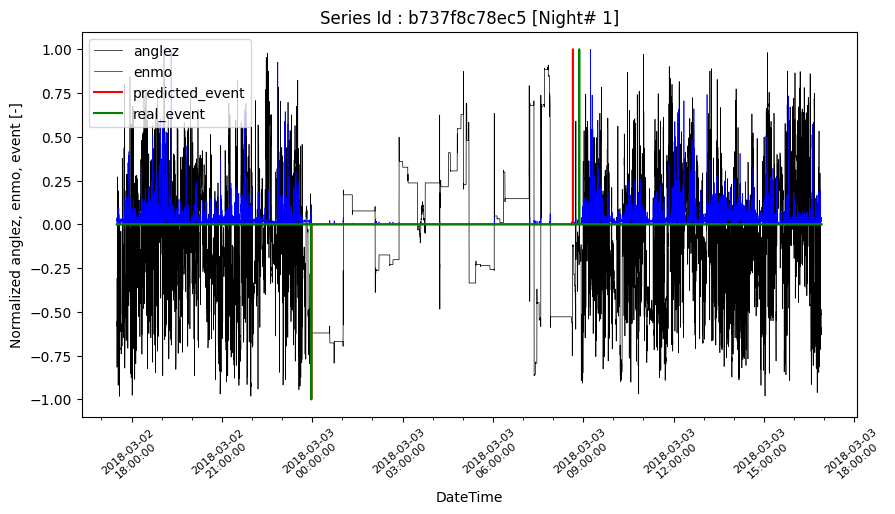

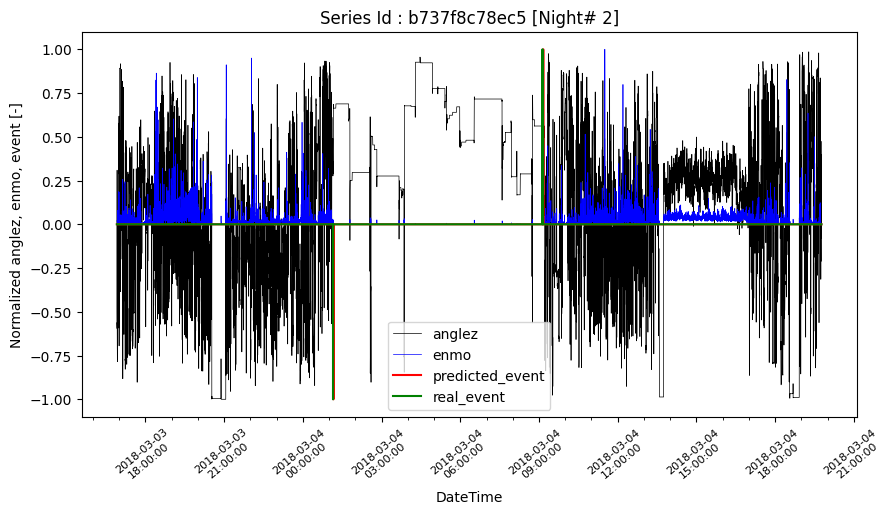

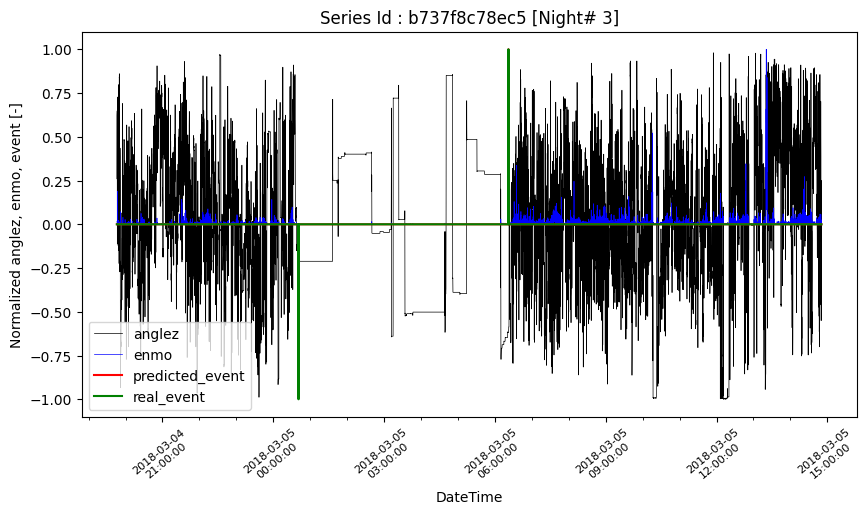

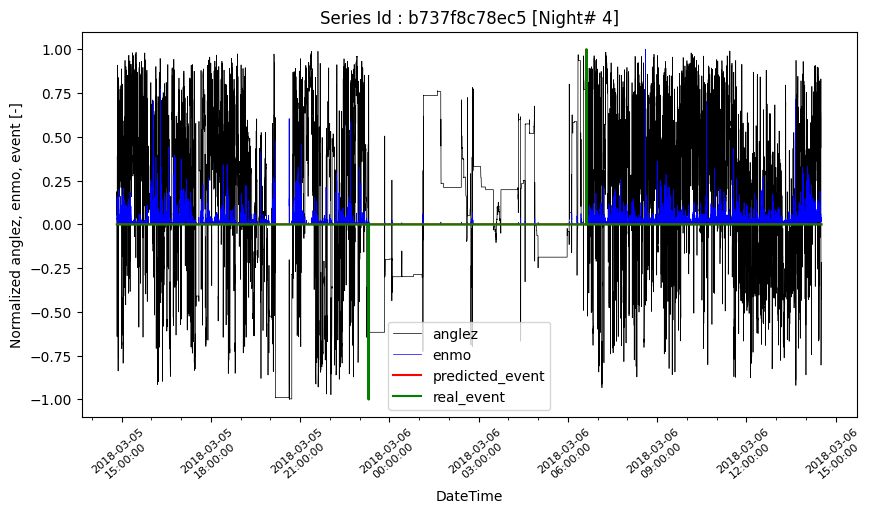

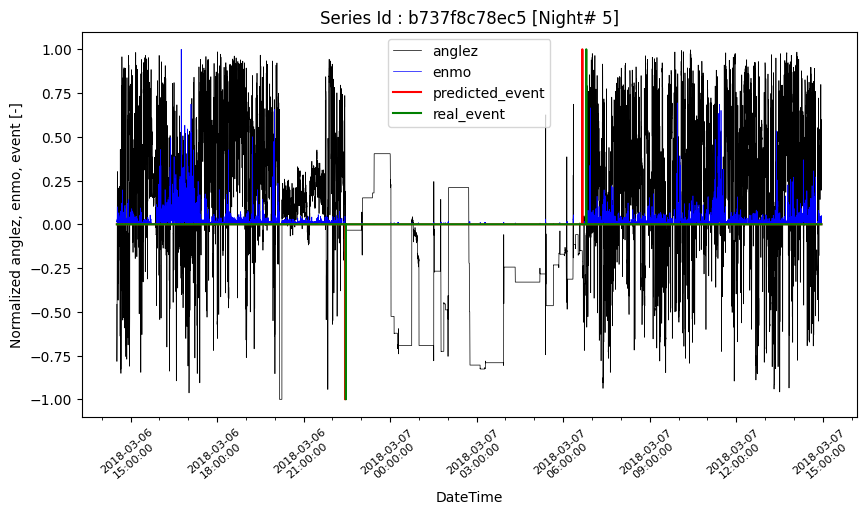

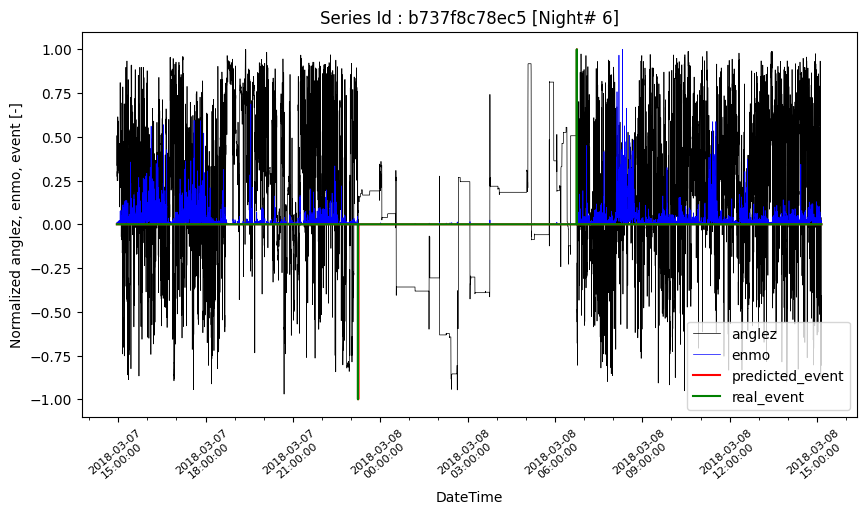

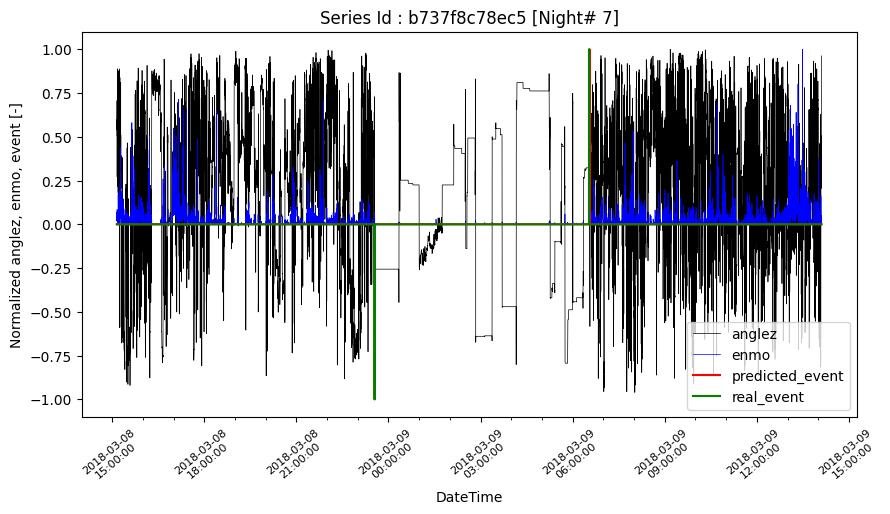

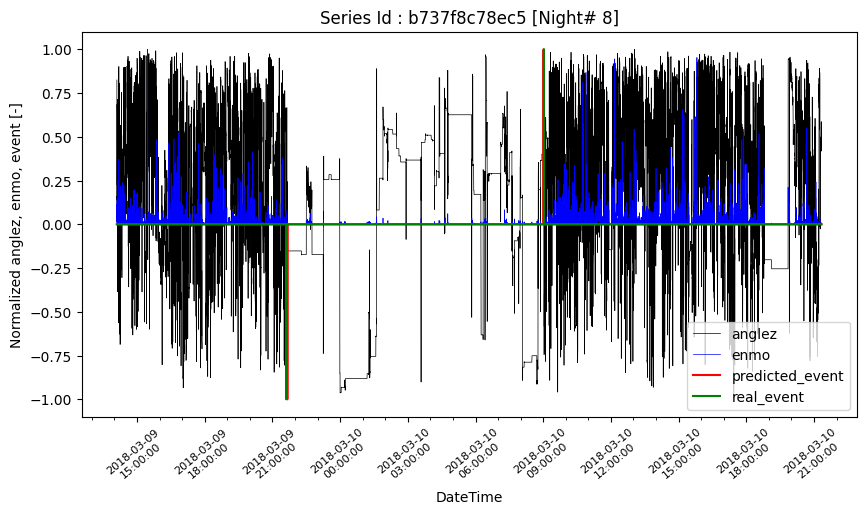

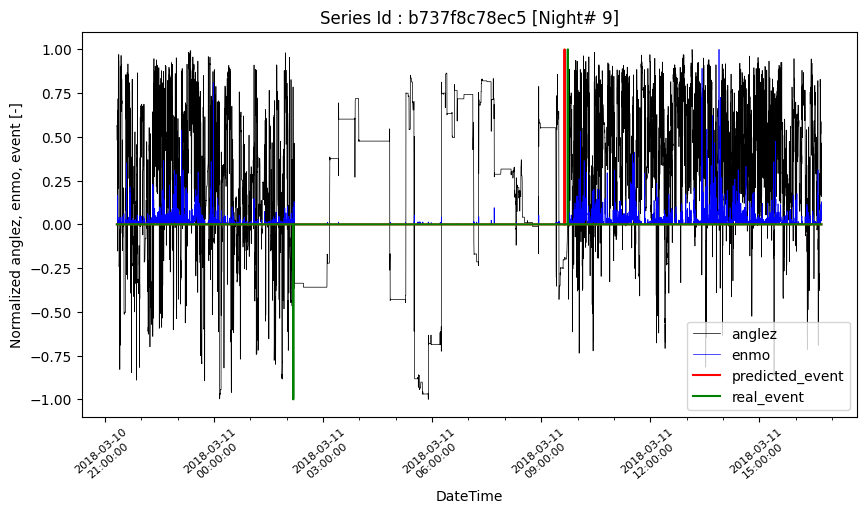

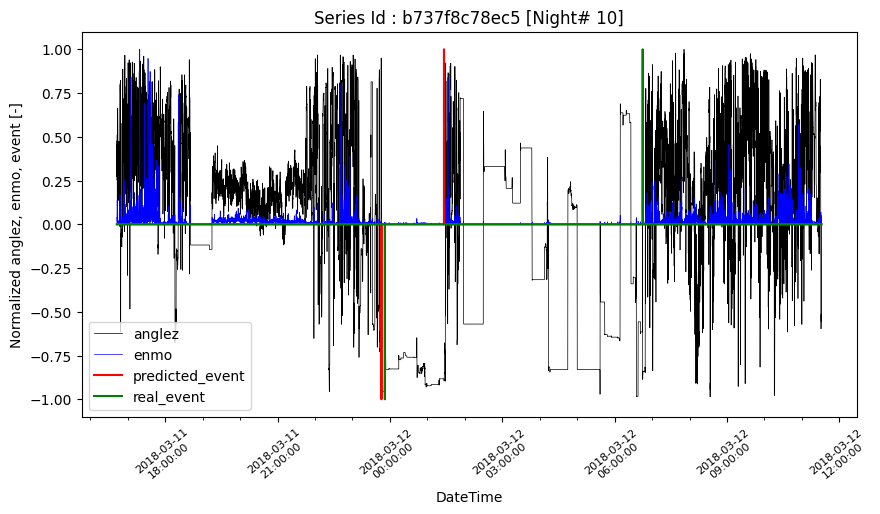

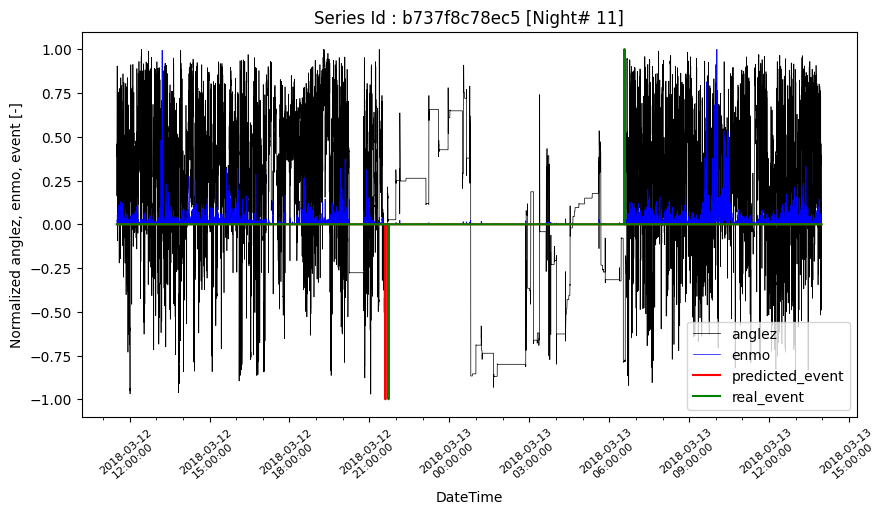

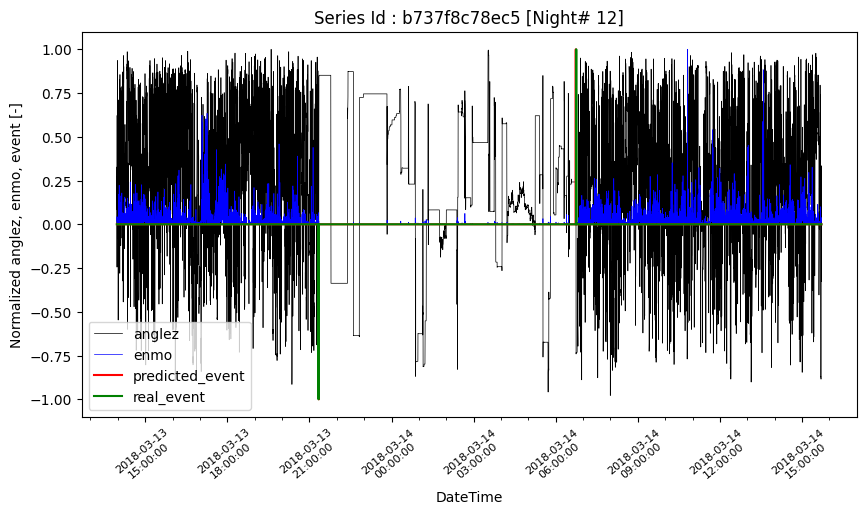

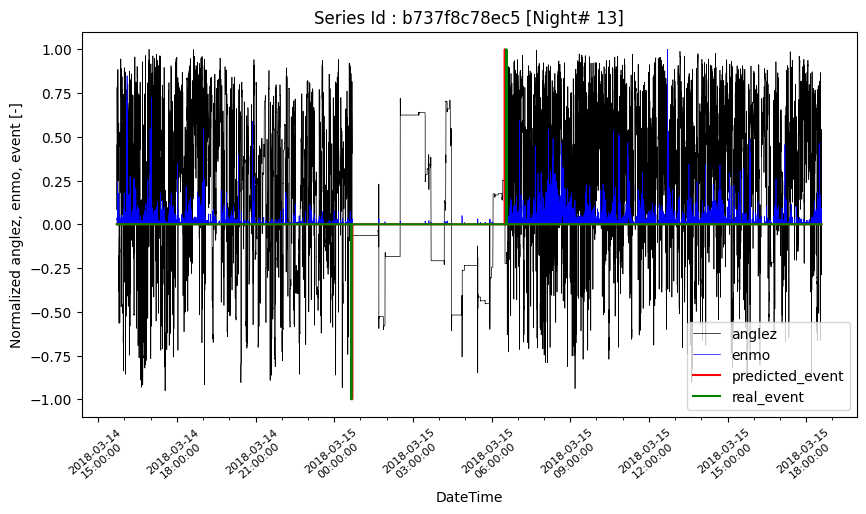

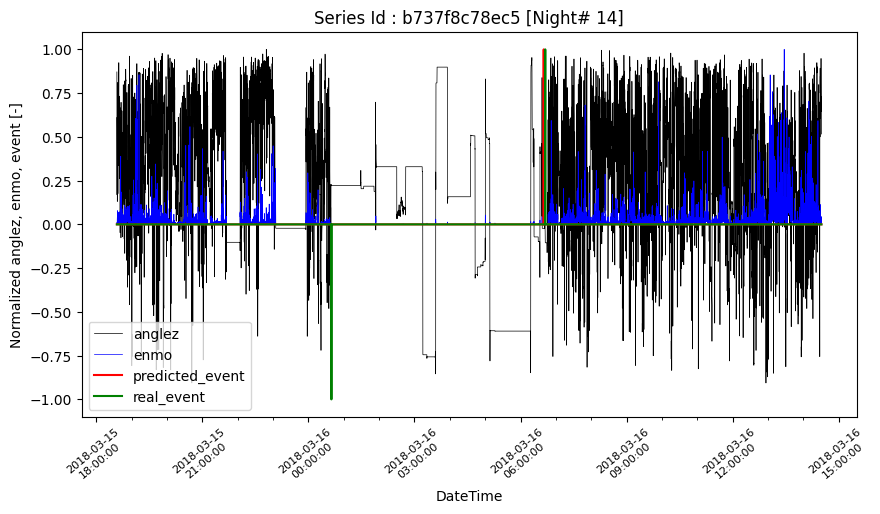

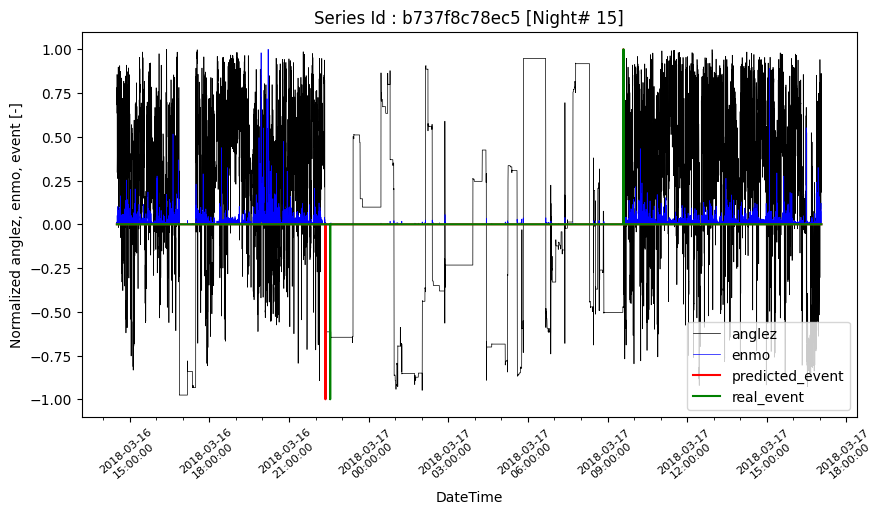

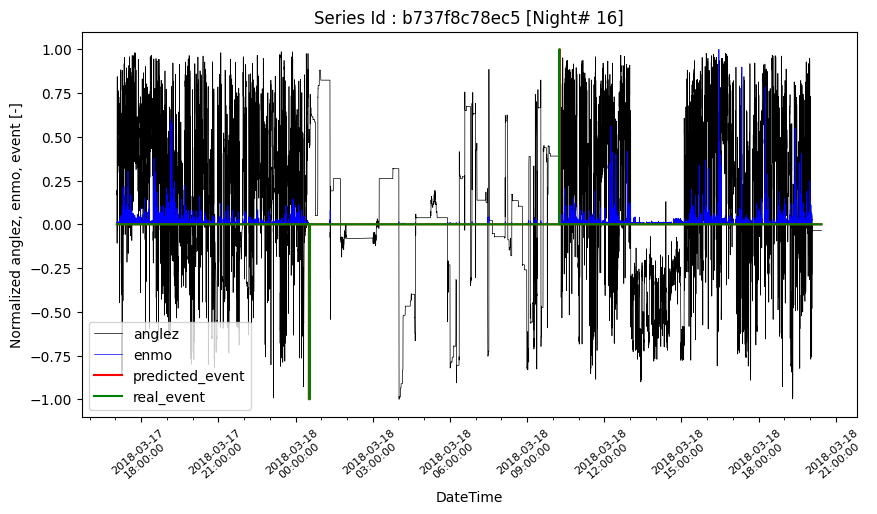

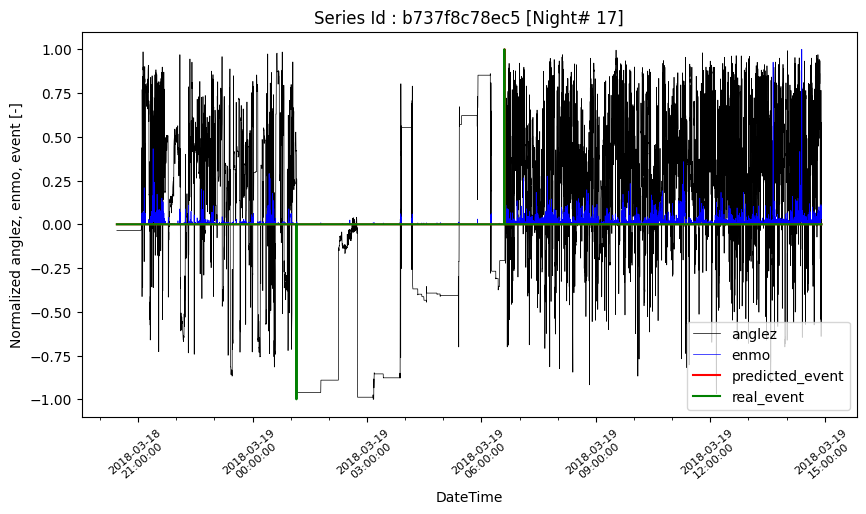

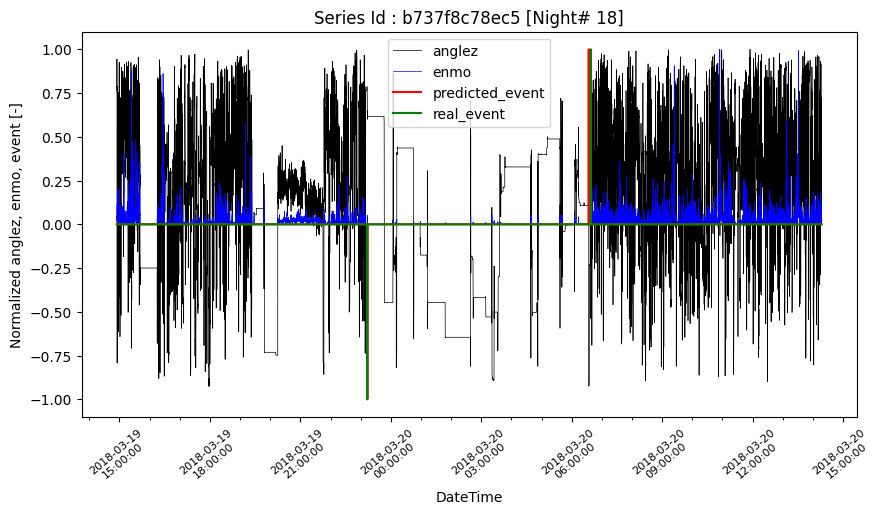

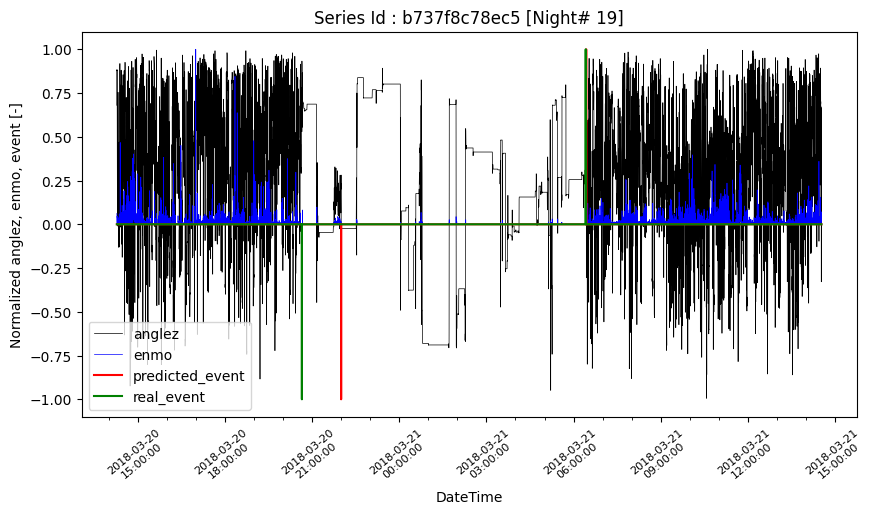

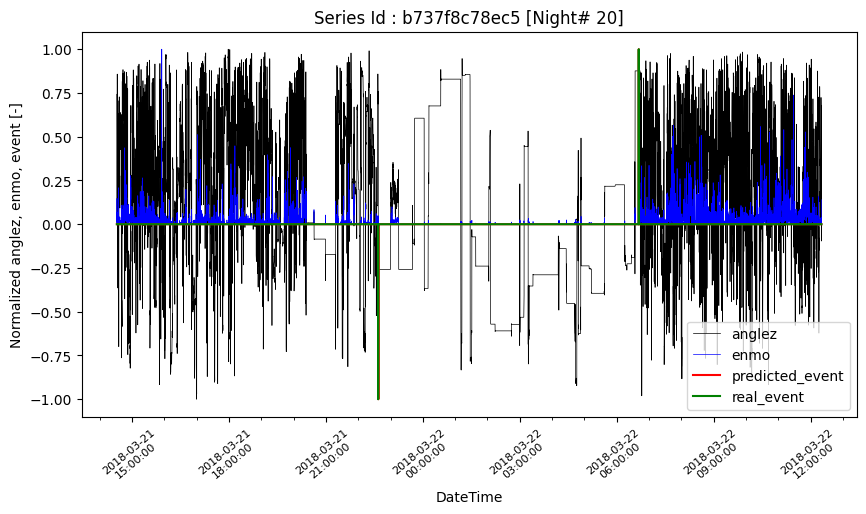

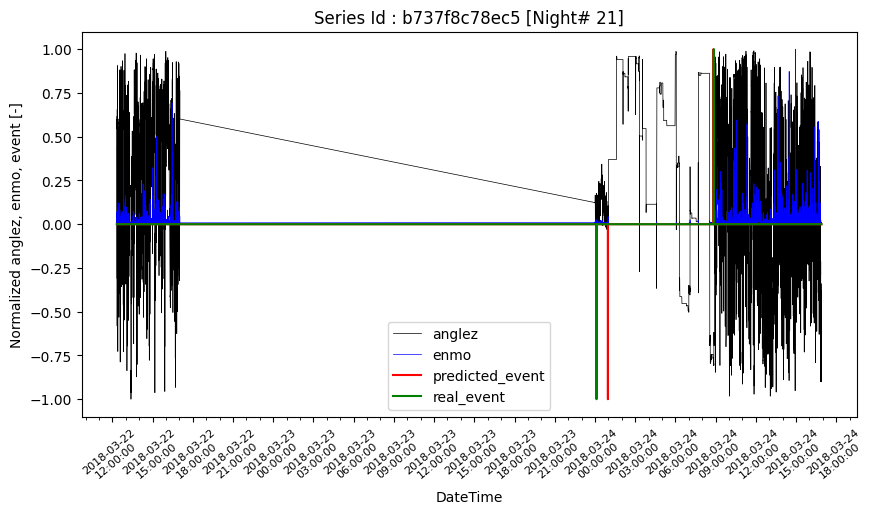

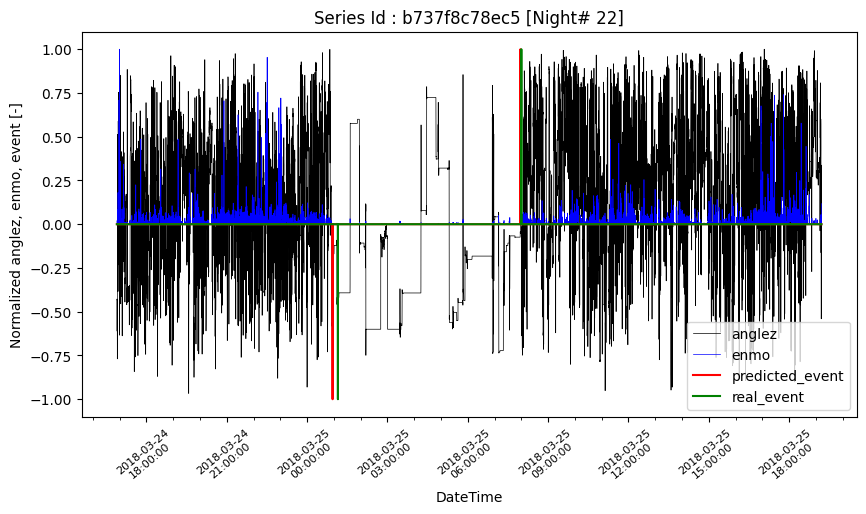

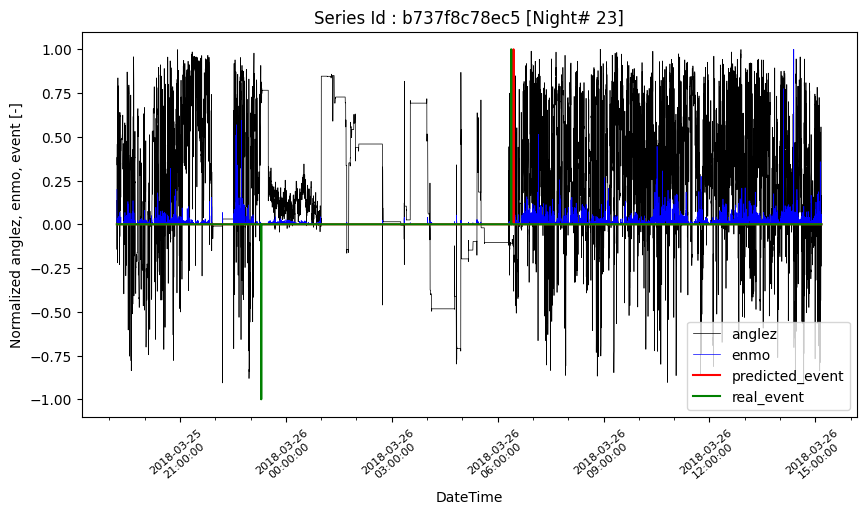

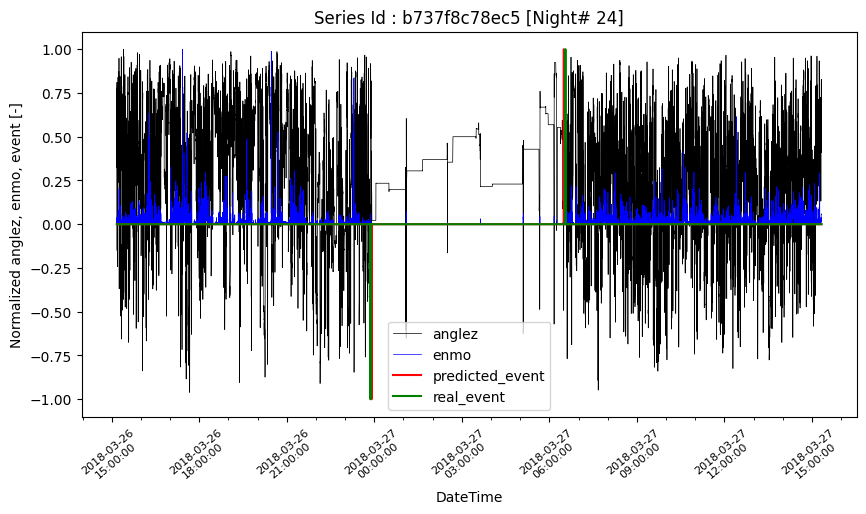

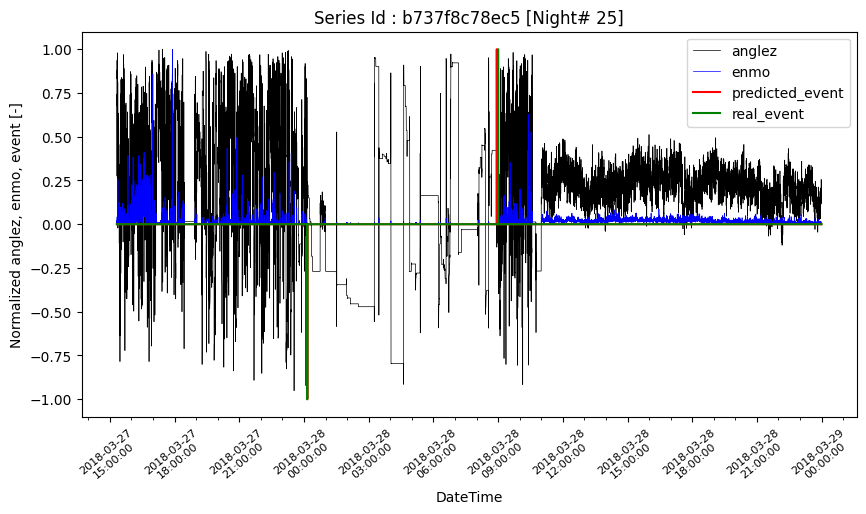

In [42]:
visualize_nights_ts_forecast(series_id_prob[0])